In [2]:
import torch
from VQ_VAE import Quantizer, Encoder, Decoder
from torchvision import datasets, transforms
from torchsummary import summary
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
from torchsummary import summary
from torch import nn
from tqdm import tqdm
import numpy as np
import pickle

In [84]:
device = 'cuda:0'
datapath = '/home/adarsh/ADRL/datasets/tiny-imagenet-200/tiny-imagenet-200/train'
modelpaths = {
    'enc' : '/home/adarsh/ADRL/assignment_1/VAE/vq_vae_enc_3.pt',
    'dec' : '/home/adarsh/ADRL/assignment_1/VAE/vq_vae_dec_3.pt',
    'quan' : '/home/adarsh/ADRL/assignment_1/VAE/vq_vae_quan_3.pt',
}

models = {
        'enc' : Encoder().to(device),
        'dec' : Decoder().to(device),
        'quan' : Quantizer(512).to(device)
    }
[ models[key].load_state_dict(torch.load(modelpaths[key])) for key in modelpaths.keys()]

modelpaths1 = {
    'enc' : '/home/adarsh/ADRL/assignment_1/VAE/vq_vae_enc_1.pt',
    'dec' : '/home/adarsh/ADRL/assignment_1/VAE/vq_vae_dec_1.pt',
    'quan' : '/home/adarsh/ADRL/assignment_1/VAE/vq_vae_quan_1.pt',
}

models1 = {
        'enc' : Encoder().to(device),
        'dec' : Decoder().to(device),
        'quan' : Quantizer(512//4).to(device)
    }
[ models1[key].load_state_dict(torch.load(modelpaths1[key])) for key in modelpaths1.keys()]

modelpaths2 = {
    'enc' : '/home/adarsh/ADRL/assignment_1/VAE/vq_vae_enc_2.pt',
    'dec' : '/home/adarsh/ADRL/assignment_1/VAE/vq_vae_dec_2.pt',
    'quan' : '/home/adarsh/ADRL/assignment_1/VAE/vq_vae_quan_2.pt',
}

models2 = {
        'enc' : Encoder().to(device),
        'dec' : Decoder().to(device),
        'quan' : Quantizer(512//2).to(device)
    }
[ models2[key].load_state_dict(torch.load(modelpaths2[key])) for key in modelpaths2.keys()]

[<All keys matched successfully>,
 <All keys matched successfully>,
 <All keys matched successfully>]

In [82]:
imagenet_transform = transforms.Compose([transforms.ToTensor()])
imagenet = datasets.ImageFolder(datapath, transform=imagenet_transform)
train_dataloader = DataLoader(imagenet, 1, shuffle=True)
rgb = transforms.ToPILImage()
images = []
i = 0
for img, _ in train_dataloader:
    images.append(img)
    i+=1
    if i==100:
        break
len(images)

100

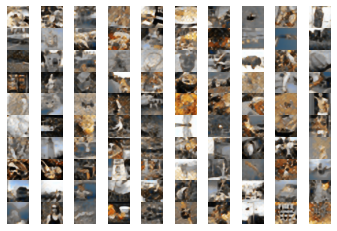

In [85]:
i=1
for X in images:
    img = rgb(models['dec'](models['quan'](models['enc'](X.to(device)))).squeeze())
    plt.subplot(10, 10, i)
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.imshow(img)
    i+=1
    if i>100:
        break
plt.savefig('/home/adarsh/ADRL/assignment_1/VAE/vqvae_512.png', dpi=300)

i=1
for X in images:
    img = rgb(models1['dec'](models1['quan'](models1['enc'](X.to(device)))).squeeze())
    plt.subplot(10, 10, i)
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.imshow(img)
    i+=1
    if i>100:
        break
plt.savefig('/home/adarsh/ADRL/assignment_1/VAE/vqvae_128.png', dpi=300)

i=1
for X in images:
    img = rgb(models2['dec'](models2['quan'](models2['enc'](X.to(device)))).squeeze())
    plt.subplot(10, 10, i)
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.imshow(img)
    i+=1
    if i>100:
        break
plt.savefig('/home/adarsh/ADRL/assignment_1/VAE/vqvae_256.png', dpi=300)

In [28]:
Z = []
with torch.no_grad():
    for X,_ in tqdm(train_dataloader):
        Z.append(models['quan'](models['enc'](X.to(device))).cpu().detach().flatten().numpy())

100%|██████████| 100000/100000 [08:01<00:00, 207.57it/s]


In [60]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(100)
gmm.fit(Z[:5000])

GaussianMixture(n_components=100)

In [30]:
with open('/home/adarsh/ADRL/assignment_1/VAE/vq_vae_gmm.pkl','wb') as pkl:
    pickle.dump(gmm, pkl, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
with open('/home/adarsh/ADRL/assignment_1/VAE/vq_vae_gmm.pkl','rb') as pkl:
    gmm = pickle.load(pkl)

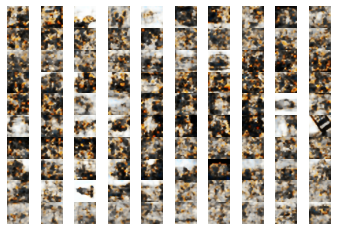

In [ ]:
samples = gmm.sample(100)
i=1
for sample in samples[0]:
    z = torch.Tensor(sample).reshape((1, 1, 16, 16)).to(device)
    img = rgb(models['dec'](models['quan'](z)).squeeze())
    plt.subplot(10, 10, i)
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.imshow(img)
    i+=1
plt.savefig('/home/adarsh/ADRL/assignment_1/VAE/vqvae_gmm.png', dpi=300)

In [48]:
from VQ_VAE import zmodel, zmodelpath, sample

zmodel.load_state_dict(torch.load(zmodelpath))

<All keys matched successfully>

In [49]:
samples = [ sample(mean=torch.zeros((64,)).to(device), std=1) for _ in range(100) ]

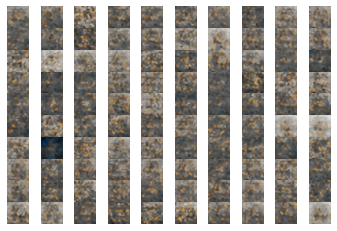

In [51]:
i=1
for z in samples:
    z = zmodel[1](z)
    z = z.reshape((1, 1, 16, 16))
    img = rgb(models['dec'](models['quan'](z)).squeeze())
    plt.subplot(10, 10, i)
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.imshow(img)
    i+=1
plt.savefig('/home/adarsh/ADRL/assignment_1/VAE/vqvae_vae.png', dpi=300)